# Logistic Regression on BRCA subset of the TCGA dataset
#### Using Logistic Regression for breast cancer subtype classification

In [50]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load and split the dataset

In [2]:
# Training set
X_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
y_train = X_train["Ciriello_subtype"]
X_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

# Final test set
X_test = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_test.pkl")
y_test = X_test["subtype"]
X_test.drop(['tcga_id', 'subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

# Order the features correctly

X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
X_test = X_test.reindex(sorted(X_test.columns), axis="columns")

In [3]:
X_train.shape

(817, 19036)

In [4]:
X_test.shape

(236, 19036)

### Scale the data

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Code to tune parameter C

In [6]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True)
for c in values:
    scores = []

    for train_index, test_index in skf.split(X_train_scaled, y_train):

        X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)

        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1

    i=1
    mean_scores.append(np.mean(scores))
    print('Results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))

#results.to_csv("parameter_tuning/LogisticRegression/tcga_c_tuning_all_genes.csv", index=False)
mean_scores

Results: [0.1696969696969697, 0.1656441717791411, 0.1656441717791411, 0.1656441717791411, 0.1656441717791411]
C: 0.001, Accuracy: 0.1664547313627068
Results: [0.503030303030303, 0.50920245398773, 0.5153374233128835, 0.50920245398773, 0.50920245398773]
C: 0.01, Accuracy: 0.5091950176612754
Results: [0.8, 0.7975460122699386, 0.7975460122699386, 0.7852760736196319, 0.803680981595092]
C: 0.1, Accuracy: 0.7968098159509202
Results: [0.8545454545454545, 0.9079754601226994, 0.8957055214723927, 0.8404907975460123, 0.8773006134969326]
C: 1, Accuracy: 0.8752035694366983
Results: [0.9272727272727272, 0.8711656441717791, 0.852760736196319, 0.8895705521472392, 0.8773006134969326]
C: 10, Accuracy: 0.8836140546569993
Results: [0.8787878787878788, 0.8895705521472392, 0.8895705521472392, 0.8834355828220859, 0.8159509202453987]
C: 100, Accuracy: 0.8714630972299684
Results: [0.8303030303030303, 0.8159509202453987, 0.8834355828220859, 0.8588957055214724, 0.8957055214723927]
C: 1000, Accuracy: 0.85685815207

[0.1664547313627068,
 0.5091950176612754,
 0.7968098159509202,
 0.8752035694366983,
 0.8836140546569993,
 0.8714630972299684,
 0.856858152072876,
 0.8409221044803866]

### We can see that C=1 is the best parameter, hence why we'll use it to test our model

In [7]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_train_scaled, y_train)

In [8]:
final_score = clf.score(X_test_scaled, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_scaled)))
print('Accuracy', final_score)

Confusion matrix
 [[ 43   0   0   0   0]
 [  0  16   0   0   0]
 [  0   1 126   4   0]
 [  0   0   2  30   0]
 [  0   3   4   1   6]]
Accuracy 0.9364406779661016


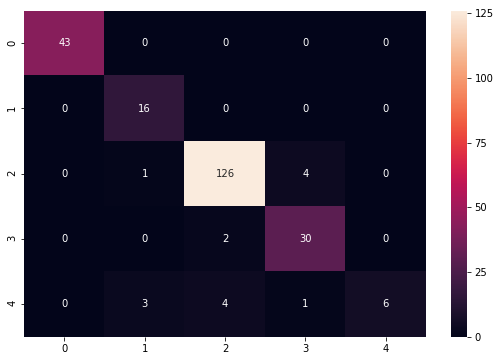

In [9]:
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)))
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
#conf_matrix.to_csv("results/LogisticRegression/tcga_confusion_matrix_all_genes.csv")

In [12]:
y_test.value_counts()

LumA      131
Basal      43
LumB       32
Her2       16
Normal     14
Name: subtype, dtype: int64

## Get data for performance_curves

In [54]:
random_gen = [10, 50, 23, 42, 4, 6, 43, 75, 22, 1]
data_percent = [1, 0.5, 0.25, 0.125]
i=1

for percent in data_percent:
    X_train_full = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
    # Training set
    
    if percent<1:
        X_train, trash = train_test_split(X_train_full, train_size=percent, stratify=X_train_full["Ciriello_subtype"], shuffle=True)
    else:
        X_train = X_train_full
        
    y_train = X_train["Ciriello_subtype"]
    X_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

    # Order the features correctly
    X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

    for s_index in range(10):
        print("SPLIT {}".format(s_index))
        
        results_df = pd.DataFrame(columns=["Fold", "Accuracy"])
        # Using different seeds for each fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_gen[s_index])
        scores = []

        for train_index, test_index in skf.split(X_train_scaled, y_train):

            X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
            y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

            clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_cv_train, y_cv_train)

            score = clf.score(X_cv_val, y_cv_val)
            results_df = results_df.append({'Fold': i, 'Accuracy' : score}, ignore_index=True)
            scores.append(score)
            i+=1
        
        i=1 
        results_df = results_df.assign(mean_accuracy=np.mean(scores))
        print('Results: {}'.format(scores))
        print('Accuracy: {}'.format(np.mean(scores)))

        output_filename="../results/performance_curves/logistic_regression/{}_brca_data_split_{}_classifier.csv".format(percent, s_index)
        results_df.to_csv(output_filename)

SPLIT 0
Results: [0.8787878787878788, 0.8834355828220859, 0.8711656441717791, 0.8957055214723927, 0.8588957055214724]
Accuracy: 0.8775980665551218
SPLIT 1
Results: [0.896969696969697, 0.8588957055214724, 0.8957055214723927, 0.8650306748466258, 0.8650306748466258]
Accuracy: 0.8763264547313627
SPLIT 2
Results: [0.8121212121212121, 0.9141104294478528, 0.8588957055214724, 0.9079754601226994, 0.901840490797546]
Accuracy: 0.8789886596021566
SPLIT 3
Results: [0.8727272727272727, 0.901840490797546, 0.8957055214723927, 0.852760736196319, 0.8650306748466258]
Accuracy: 0.8776129392080312
SPLIT 4
Results: [0.9090909090909091, 0.8711656441717791, 0.901840490797546, 0.8773006134969326, 0.8404907975460123]
Accuracy: 0.8799776910206358
SPLIT 5
Results: [0.8787878787878788, 0.8773006134969326, 0.8466257668711656, 0.9079754601226994, 0.8834355828220859]
Accuracy: 0.8788250604201524
SPLIT 6
Results: [0.8424242424242424, 0.8650306748466258, 0.8588957055214724, 0.8895705521472392, 0.8588957055214724]
Accur

/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


SPLIT 0
Results: [0.8690476190476191, 0.8333333333333334, 0.8658536585365854, 0.8607594936708861, 0.8860759493670886]
Accuracy: 0.8630140107911025
SPLIT 1
Results: [0.8928571428571429, 0.8690476190476191, 0.8536585365853658, 0.8987341772151899, 0.8481012658227848]
Accuracy: 0.8724797483056204
SPLIT 2
Results: [0.8214285714285714, 0.8690476190476191, 0.8536585365853658, 0.8481012658227848, 0.8734177215189873]
Accuracy: 0.8531307428806658
SPLIT 3
Results: [0.8333333333333334, 0.7738095238095238, 0.8780487804878049, 0.8607594936708861, 0.8607594936708861]
Accuracy: 0.8413421249944868
SPLIT 4
Results: [0.8809523809523809, 0.8333333333333334, 0.8536585365853658, 0.8481012658227848, 0.7721518987341772]
Accuracy: 0.8376394830856084
SPLIT 5
Results: [0.8809523809523809, 0.8928571428571429, 0.7682926829268293, 0.8860759493670886, 0.8481012658227848]
Accuracy: 0.8552558843852452
SPLIT 6
Results: [0.8690476190476191, 0.8214285714285714, 0.8658536585365854, 0.8734177215189873, 0.8734177215189873]


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


SPLIT 0
Results: [0.8372093023255814, 0.7560975609756098, 0.7804878048780488, 0.8536585365853658, 0.7894736842105263]
Accuracy: 0.8033853777950265
SPLIT 1
Results: [0.7906976744186046, 0.8536585365853658, 0.7804878048780488, 0.7560975609756098, 0.7894736842105263]
Accuracy: 0.7940830522136311
SPLIT 2
Results: [0.7674418604651163, 0.7073170731707317, 0.8536585365853658, 0.7804878048780488, 0.8157894736842105]
Accuracy: 0.7849389497566946
SPLIT 3
Results: [0.813953488372093, 0.7317073170731707, 0.8048780487804879, 0.7804878048780488, 0.8421052631578947]
Accuracy: 0.794626384452339
SPLIT 4
Results: [0.6976744186046512, 0.7560975609756098, 0.8292682926829268, 0.8780487804878049, 0.8947368421052632]
Accuracy: 0.8111651789712511
SPLIT 5
Results: [0.8837209302325582, 0.7804878048780488, 0.7073170731707317, 0.8048780487804879, 0.868421052631579]
Accuracy: 0.808964981938681
SPLIT 6
Results: [0.7906976744186046, 0.8292682926829268, 0.7804878048780488, 0.8048780487804879, 0.7631578947368421]
Accu

/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SPLIT 0
Results: [0.7391304347826086, 0.7727272727272727, 0.85, 0.8333333333333334, 0.7894736842105263]
Accuracy: 0.7969329450107482
SPLIT 1


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.782608695652174, 0.85, 0.7222222222222222, 0.7368421052631579]
Accuracy: 0.7910618773547836
SPLIT 2


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.7391304347826086, 0.8, 0.7894736842105263, 0.8888888888888888]
Accuracy: 0.8162258743036777
SPLIT 3


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.7272727272727273, 0.75, 0.8421052631578947, 0.8888888888888888]
Accuracy: 0.798175114994337
SPLIT 4


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.8181818181818182, 0.75, 0.8888888888888888, 0.7894736842105263]
Accuracy: 0.8058306173866814
SPLIT 5


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8181818181818182, 0.8636363636363636, 0.7, 0.6842105263157895, 0.7894736842105263]
Accuracy: 0.7711004784688995
SPLIT 6


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.6956521739130435, 0.65, 0.8421052631578947, 0.7777777777777778]
Accuracy: 0.7658343156970159
SPLIT 7


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.7391304347826086, 0.8636363636363636, 0.75, 0.8333333333333334, 0.8421052631578947]
Accuracy: 0.8056410789820401
SPLIT 8


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.7391304347826086, 0.8421052631578947, 0.6842105263157895, 0.8888888888888888]
Accuracy: 0.7873887617594711
SPLIT 9


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.7391304347826086, 0.782608695652174, 0.6842105263157895, 0.7894736842105263, 0.8333333333333334]
Accuracy: 0.7657513348588864
